# Trabajo Final. Modelos de IA. 

## Red Neuronal Recurente con LSTM (memoria a corto-largo plazo)
A continuación, podemos implementar esta red neuronal en Python haciendo uso de TensorFlow/Keras. 

En este primer trabajo, vamos a hacer una separación simple de 80% para entrenar y 20% para evaluar. El objeto es esudiar y trabajar en ajustar la red neuronal a una configuración apropiada antes de aplicar un método de separación más avanzado. 

In [3]:
# Importamos las librerías necesarias
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential # Modelo secuencial
from tensorflow.keras.layers import LSTM, Dense, Embedding # Capa de embedding
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report # Matriz de confusión
from tensorflow.keras.callbacks import EarlyStopping # Early stopping

#cargamos el dataset que vamos a utilizar

# Es necesario instalar la librería openpyxl para leer archivos Excel, ejecutando el siguiente comando:
# !pip install openpyxl

# Cargamos el dataset desde la URL de GitHub
news = pd.read_excel(
    'https://github.com/Pelli223/aiiotFakeNews/raw/06f20a2ba1bdcbf89042f7a1348af6d7893fc300/datos_limpios_estandarizados.xlsx',
    engine='openpyxl'
)

# Verificamos si el dataset se ha cargado correctamente
if news is not None:
    print("Dataset cargado correctamente.")
    print("Número de filas en el dataset:", len(news))
    print("Número de columnas en el dataset:", len(news.columns))
else:
    print("Error al cargar el dataset.")
    exit

Dataset cargado correctamente.
Número de filas en el dataset: 18045
Número de columnas en el dataset: 23


In [4]:
#Preprocesamiento del texto

# Tokenizar los títulos y texto
# Aseguramos que los valores en las columnas sean cadenas de texto
news["contenido"] = news["title"].astype(str) + " " + news["text"].astype(str) # Concatenamos el título y el texto
tokenizer = Tokenizer(num_words=5000, oov_token="<OOV>") # Creamos el tokenizador
tokenizer.fit_on_texts(news["contenido"]) # Ajustamos el tokenizador a los títulos y texto concatenados

news["contenido"]

#Convertimos el texto a secuencias
secuencias = tokenizer.texts_to_sequences(news["contenido"]) # Convertimos el texto a secuencias
secuencias = pad_sequences(secuencias, maxlen=200, padding='post', truncating='post') # Rellenamos las secuencias para que tengan la misma longitud

# Seleccionamos las columnas categoricas
categorias = news.iloc[:, 3:17].values # Categorías y fuentes (16 columnas). 

# Fusionar datos de texto y categorías
final = np.hstack((secuencias, categorias)) # Fusionamos las secuencias y las categorías

# Usamos el word_count y chart_count como características numéricas
wc = news["word_count"].values.reshape(-1, 1) # Contador de palabras
cc = news["char_count"].values.reshape(-1, 1) # Contador de gráficos

# Agregamos estas caracteristicas al conjunto de datos
final = np.hstack((final, wc, cc)) # Fusionamos las secuencias y las categorías

# Extraemos los valores de año, mes y día
fecha = news[['year', 'month', 'day']].values # Extraemos los valores de año, mes y día

# Fusionamos los datos de fecha con el resto de los datos
final = np.hstack((final, fecha)) # Fusionamos los datos de fecha con el resto de los datos

In [5]:
# Dividimos el dataset en entrenamiento y prueba
# 80% entrenamiento, 20% prueba

# La columna "label" es nuestra variable objetivo
y = news["label"].values # Variable objetivo

# Dividimos el dataset en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(final, y, test_size=0.2, random_state=42) # Dividimos el dataset en entrenamiento y prueba

c:\Users\aleja\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/35
452/452 ━━━━━━━━━━━━━━━━━━━━ 81s 156ms/step - accuracy: 0.5014 - loss: 0.6935 - val_accuracy: 0.5129 - val_loss: 0.6930
Epoch 2/35
452/452 ━━━━━━━━━━━━━━━━━━━━ 70s 155ms/step - accuracy: 0.5102 - loss: 0.6928 - val_accuracy: 0.5085 - val_loss: 0.6931
Epoch 3/35
452/452 ━━━━━━━━━━━━━━━━━━━━ 70s 155ms/step - accuracy: 0.5523 - loss: 0.6868 - val_accuracy: 0.5035 - val_loss: 0.6979
Epoch 4/35
452/452 ━━━━━━━━━━━━━━━━━━━━ 70s 155ms/step - accuracy: 0.5845 - loss: 0.6760 - val_accuracy: 0.5082 - val_loss: 0.7009
Epoch 5/35
452/452 ━━━━━━━━━━━━━━━━━━━━ 82s 180ms/step - accuracy: 0.5953 - loss: 0.6683 - val_accuracy: 0.5085 - val_loss: 0.7002
Epoch 6/35
452/452 ━━━━━━━━━━━━━━━━━━━━ 73s 161ms/step - accuracy: 0.6050 - loss: 0.6615 - val_accuracy: 0.5187 - val_loss: 0.7125


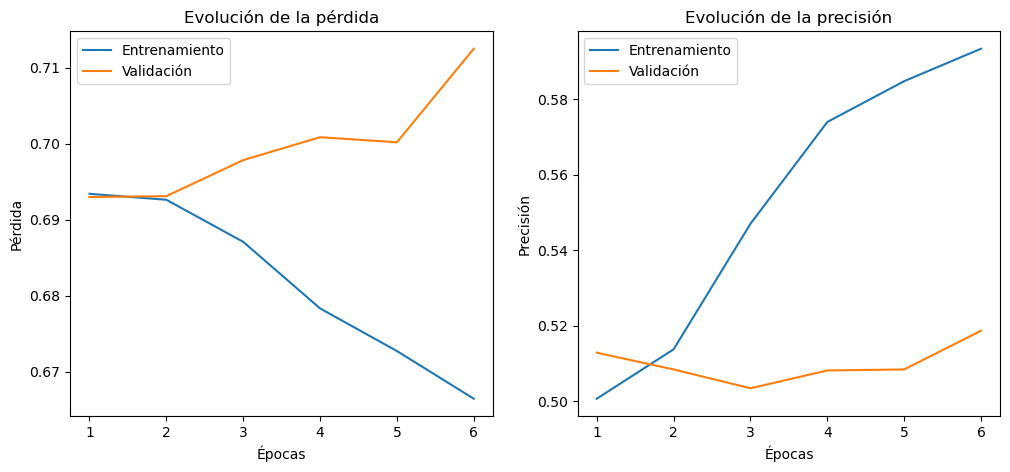

In [6]:
modelo = Sequential([
    Embedding(input_dim=5000, output_dim=64, input_length=secuencias.shape[1]), 
    LSTM(50,activation='tanh', dropout=0.3), # Capa LSTM con 50 unidades y función de activación tanh. dropout del 30% para evitar el sobreajuste
    Dense(16, activation='relu'), # Procesa categorías y fuentes. relu es la función de activación que se utiliza para la capa oculta
    Dense(1, activation='sigmoid') # Capa de salida. Salida binaria (noticia falsa o no)
]) # Modelo secuencial con una capa de embedding, una capa LSTM y dos capas densas

# Compilamos el modelo
modelo.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy']) # Compilamos el modelo con el optimizador Adam y la función de pérdida binary_crossentropy

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True) # Early stopping para evitar el sobreajuste. Monitorea la pérdida de validación y restaura los mejores pesos

# Entrenamos el modelo con datos de validación
historial = modelo.fit(X_train, y_train, epochs=35, batch_size=32, validation_data=(X_test, y_test), callbacks=[early_stop]) # Entrenamos el modelo con 35 épocas y tamaño de lote de 32.

# Obtener los datos de pérdida y precisión
epochs = range(1, len(historial.history['loss']) + 1)

# Gráfico de pérdida
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, historial.history['loss'], label='Entrenamiento')
plt.plot(epochs, historial.history['val_loss'], label='Validación')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.title('Evolución de la pérdida')
plt.legend()

# Gráfico de precisión
plt.subplot(1, 2, 2)
plt.plot(epochs, historial.history['accuracy'], label='Entrenamiento')
plt.plot(epochs, historial.history['val_accuracy'], label='Validación')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.title('Evolución de la precisión')
plt.legend()

plt.show()


In [7]:
# Evaluamos el modelo usando solo las secuencias de texto (como en el entrenamiento)
accuracy = modelo.evaluate(secuencias, news["label"])[1] # Evaluamos el modelo con las secuencias de texto. news["label"] es la variable objetivo.
print(f"Precisión del modelo con todas las columnas y LSTM: {accuracy:.2f}")

564/564 ━━━━━━━━━━━━━━━━━━━━ 32s 50ms/step - accuracy: 0.4985 - loss: 0.6932
Precisión del modelo con todas las columnas y LSTM: 0.51


In [8]:
nuevo_texto = "Joe Biden, Presidente de EEUU, ha dimitido."
# Convertimos el nuevo texto a secuencias
secuenca = tokenizer.texts_to_sequences([nuevo_texto]) # Convertimos el texto a secuencias
secuencia_padded = pad_sequences(secuenca, maxlen=200, padding='post', truncating='post') # Rellenamos la secuencia para que tenga la misma longitud

## Supongamos que pertenece a la categoría "Política" y es de "CNN"
nuevas_caracteristicas = np.array([[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 200, 1500]])  # Simulación de valores

# Concatenamos la secuencia con las nuevas características
entrada_final = np.hstack((secuencia_padded, nuevas_caracteristicas)) # Fusionamos la secuencia y las nuevas características

# Realizamos la predicción
predicciones = modelo.predict(entrada_final) # Predecimos el nuevo texto
print(f"Predicción para el nuevo texto: {predicciones[0][0]:.2f}") # Mostramos la predicción
# Mostramos la predicción

# convertir la predicción a una etiqueta
Etiqueta = "Noticia falsa" if predicciones[0][0] > 0.4 else "Noticia verdadera"

print(f"Esta es una {Etiqueta}") # Mostramos la etiqueta

# Convertir las probabilidades en etiquetas binarias (0 = verdadero, 1 = falso)
predicciones_binario = np.where(predicciones >= 0.4, 1, 0)

# Evaluar el modelo con el conjunto de prueba
predicciones_test = modelo.predict(X_test)
predicciones_test_binario = np.where(predicciones_test >= 0.4, 1, 0)
matriz_confusion = confusion_matrix(y_test, predicciones_test_binario)
print("Matriz de confusión:")
print(matriz_confusion)
print("Explicación de la matriz de confusión:")
print("[TN, FP]")
print("[FN, TP]")

reporte_clasificacion = classification_report(y_test, predicciones_test_binario)
print("Reporte de clasificación:")
print(reporte_clasificacion)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 904ms/step
Predicción para el nuevo texto: 0.50
Esta es una Noticia falsa
113/113 ━━━━━━━━━━━━━━━━━━━━ 7s 58ms/step
Matriz de confusión:
[[   0 1846]
 [   0 1763]]
Explicación de la matriz de confusión:
[TN, FP]
[FN, TP]
Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1846
           1       0.49      1.00      0.66      1763

    accuracy                           0.49      3609
   macro avg       0.24      0.50      0.33      3609
weighted avg       0.24      0.49      0.32      3609



c:\Users\aleja\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\aleja\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\aleja\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


# IA Explicativa (XAI)
A continuación, desarrollamos los sistemas explicativos:
- SHAP. Nos dirá qué características (como el texto, categoría, fuente, word_count, etc.) tienen más impacto en la predicción.
- LIME. Se utiliza para generar explicaciones locales para casos específicos.

C:\Users\aleja\AppData\Local\Temp\ipykernel_26060\4153495241.py:22: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values_lstm, X_test_sample, feature_names=feature_names, max_display=10)


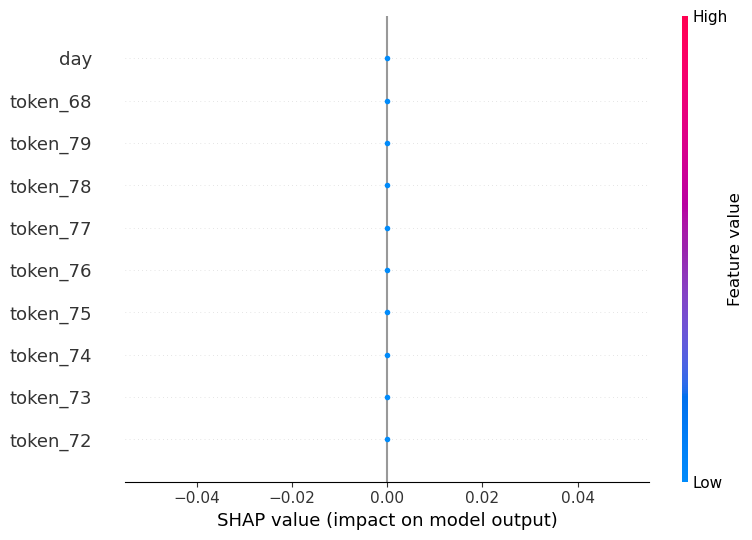

157/157 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step


In [ ]:
# Aplicación de SHAP para explicar el modelo LSTM
import shap
import lime
import lime.lime_tabular

#reducimos el tamaño del conjunto de datos para SHAP
sample_size = 100
X_test_sample = X_test[:sample_size] # Tomamos una muestra del conjunto de prueba

# Crear un objeto SHAP explainer para LSTM
explainer_lstm = shap.Explainer(modelo, X_test_sample)
shap_values_lstm = explainer_lstm(X_test_sample)

# Visualización de características más importantes para LSTM
# Construir la lista de nombres de características para todas las columnas de X_test_sample
# Primero los nombres de los tokens
token_feature_names = [f"token_{i}" for i in range(secuencias.shape[1])]
# Luego los nombres de las columnas categóricas y numéricas
other_feature_names = list(news.columns[3:17]) + ["word_count", "char_count", "year", "month", "day"]
feature_names = token_feature_names + other_feature_names

shap.summary_plot(shap_values_lstm, X_test_sample, feature_names=feature_names, max_display=10)

# Aplicación de LIME para explicar el modelo LSTM
explainer_lime = lime.lime_tabular.LimeTabularExplainer(training_data=X_train,
                                                        feature_names=feature_names, # Usamos los nombres correctos de las características
                                                        mode='classification')

idx = 10 # Índice de la instancia a explicar (ajustado para evitar IndexError)

# Asegurarse de que idx esté dentro del rango de X_test
if idx < len(X_test):
    # LIME espera una función que devuelva probabilidades para ambas clases
    def predict_proba_lime(x):
        p = modelo.predict(x)
        return np.hstack([1 - p, p])

    exp_lstm = explainer_lime.explain_instance(X_test[idx], predict_proba_lime, num_features=5)
    exp_lstm.show_in_notebook(show_table=True, show_all=False) # Mostrar la explicación en el cuaderno
else:
    print(f"El índice idx={idx} está fuera del rango de X_test (tamaño={len(X_test)}).")

# KFold Cross Validation, con K = 5.



In [7]:
# Importamos las librerías necesarias
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential # Modelo secuencial
from tensorflow.keras.layers import LSTM, Dense, Embedding # Capa de embedding
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix, classification_report # Matriz de confusión
from tensorflow.keras.callbacks import EarlyStopping # Early stopping


# Cargamos el dataset que vamos a utilizar

# Es necesario instalar la librería openpyxl para leer archivos Excel, ejecutando el siguiente comando:
# !pip install openpyxl

# Cargamos el dataset desde la URL de GitHub
news = pd.read_excel(
    'https://github.com/Pelli223/aiiotFakeNews/raw/06f20a2ba1bdcbf89042f7a1348af6d7893fc300/datos_limpios_estandarizados.xlsx',
    engine='openpyxl'
)

# Verificamos si el dataset se ha cargado correctamente

if news is not None:
    print("Dataset cargado correctamente.")
    print("Número de filas en el dataset:", len(news))
    print("Número de columnas en el dataset:", len(news.columns))   
else:
    print("Error al cargar el dataset.")
    exit

Dataset cargado correctamente.
Número de filas en el dataset: 18045
Número de columnas en el dataset: 23


In [8]:
# Preprocesamiento del texto

# Tokenizar los títulos y texto
# Aseguramos que los valores en las columnas sean cadenas de texto
news["contenido"] = news["title"].astype(str) + " " + news["text"].astype(str) # Concatenamos el título y el texto
tokenizer = Tokenizer(num_words=5000, oov_token="<OOV>") # Creamos el tokenizador
tokenizer.fit_on_texts(news["contenido"]) # Ajustamos el tokenizador a los títulos y texto concatenados
news["contenido"]

# Convertimos el texto a secuencias
secuencias = tokenizer.texts_to_sequences(news["contenido"]) # Convertimos el texto a secuencias
secuencias = pad_sequences(secuencias, maxlen=200, padding='post', truncating='post') # Rellenamos las secuencias para que tengan la misma longitud

# Seleccionamos las columnas categoricas
categorias = news.iloc[:, 3:17].values # Categorías y fuentes (16 columnas).

# Fusionar datos de texto y categorías
final = np.hstack((secuencias, categorias)) # Fusionamos las secuencias y las categorías

# Usamos el word_count y chart_count como características numéricas
wc = news["word_count"].values.reshape(-1, 1) # Contador de palabras
cc = news["char_count"].values.reshape(-1, 1) # Contador de gráficos

# Agregamos estas caracteristicas al conjunto de datos
final = np.hstack((final, wc, cc)) # Fusionamos las secuencias y las categorías

# Extraemos los valores de año, mes y día
fecha = news[['year', 'month', 'day']].values # Extraemos los valores de año, mes y día

# Fusionamos los datos de fecha con el resto de los datos
final = np.hstack((final, fecha)) # Fusionamos los datos de fecha con el resto de los datos

Epoch 1/35


c:\Users\aleja\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


452/452 ━━━━━━━━━━━━━━━━━━━━ 97s 208ms/step - accuracy: 0.4987 - loss: 0.6935 - val_accuracy: 0.5037 - val_loss: 0.6930
Epoch 2/35
452/452 ━━━━━━━━━━━━━━━━━━━━ 66s 147ms/step - accuracy: 0.5229 - loss: 0.6923 - val_accuracy: 0.5007 - val_loss: 0.6930
Epoch 3/35
452/452 ━━━━━━━━━━━━━━━━━━━━ 66s 146ms/step - accuracy: 0.5587 - loss: 0.6842 - val_accuracy: 0.5098 - val_loss: 0.6947
Epoch 4/35
452/452 ━━━━━━━━━━━━━━━━━━━━ 66s 146ms/step - accuracy: 0.5946 - loss: 0.6708 - val_accuracy: 0.5112 - val_loss: 0.7085
Epoch 5/35
452/452 ━━━━━━━━━━━━━━━━━━━━ 57s 127ms/step - accuracy: 0.6150 - loss: 0.6536 - val_accuracy: 0.4996 - val_loss: 0.7224
Epoch 6/35
452/452 ━━━━━━━━━━━━━━━━━━━━ 169s 373ms/step - accuracy: 0.6361 - loss: 0.6396 - val_accuracy: 0.5048 - val_loss: 0.7248
Epoch 7/35
452/452 ━━━━━━━━━━━━━━━━━━━━ 507s 1s/step - accuracy: 0.6665 - loss: 0.6156 - val_accuracy: 0.5021 - val_loss: 0.7464


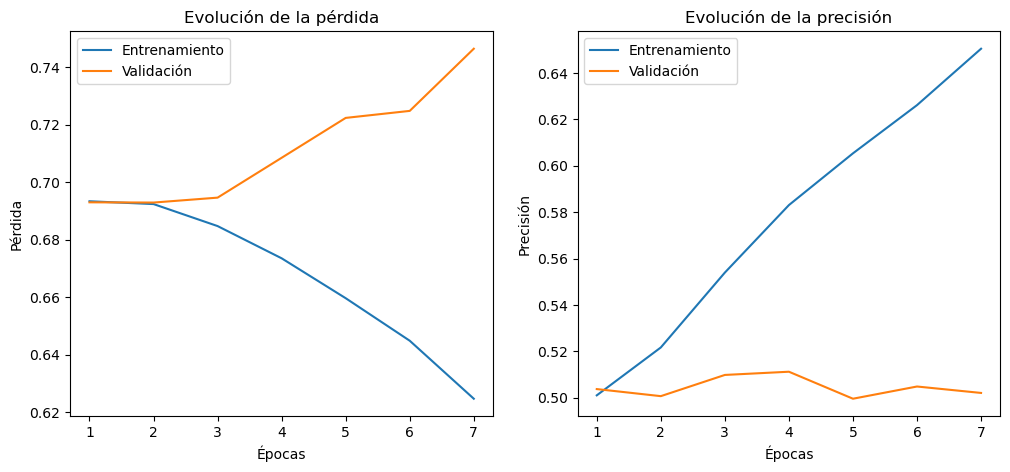

113/113 ━━━━━━━━━━━━━━━━━━━━ 9s 82ms/step - accuracy: 0.4901 - loss: 0.6938
Epoch 1/35
452/452 ━━━━━━━━━━━━━━━━━━━━ 537s 1s/step - accuracy: 0.4991 - loss: 0.6934 - val_accuracy: 0.4974 - val_loss: 0.6935
Epoch 2/35
452/452 ━━━━━━━━━━━━━━━━━━━━ 220s 481ms/step - accuracy: 0.5180 - loss: 0.6918 - val_accuracy: 0.4993 - val_loss: 0.6942
Epoch 3/35
452/452 ━━━━━━━━━━━━━━━━━━━━ 149s 331ms/step - accuracy: 0.5608 - loss: 0.6836 - val_accuracy: 0.4999 - val_loss: 0.7005
Epoch 4/35
452/452 ━━━━━━━━━━━━━━━━━━━━ 206s 339ms/step - accuracy: 0.5836 - loss: 0.6752 - val_accuracy: 0.4938 - val_loss: 0.7081
Epoch 5/35
452/452 ━━━━━━━━━━━━━━━━━━━━ 52s 115ms/step - accuracy: 0.6004 - loss: 0.6649 - val_accuracy: 0.4860 - val_loss: 0.7274
Epoch 6/35
452/452 ━━━━━━━━━━━━━━━━━━━━ 51s 113ms/step - accuracy: 0.6177 - loss: 0.6532 - val_accuracy: 0.4855 - val_loss: 0.7398


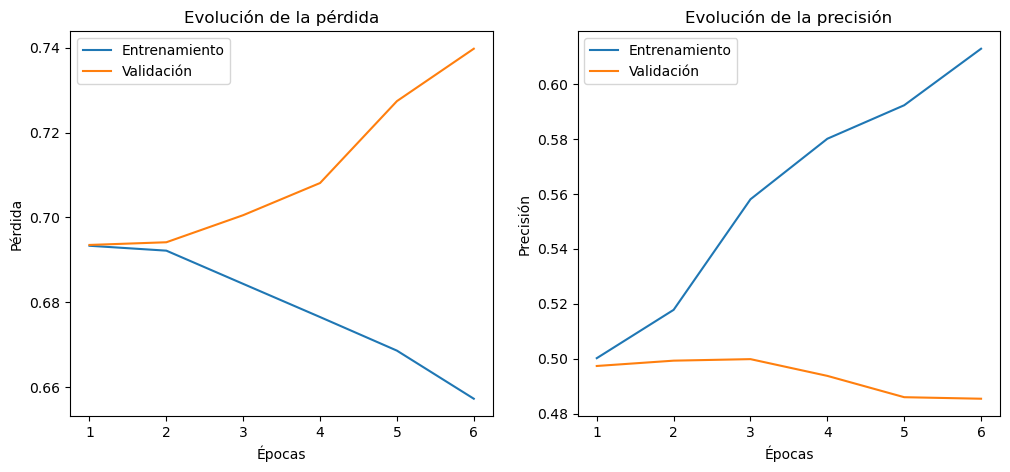

113/113 ━━━━━━━━━━━━━━━━━━━━ 7s 65ms/step - accuracy: 0.5118 - loss: 0.6928
Epoch 1/35
452/452 ━━━━━━━━━━━━━━━━━━━━ 78s 118ms/step - accuracy: 0.5051 - loss: 0.6934 - val_accuracy: 0.5035 - val_loss: 0.6933
Epoch 2/35
452/452 ━━━━━━━━━━━━━━━━━━━━ 71s 158ms/step - accuracy: 0.5185 - loss: 0.6920 - val_accuracy: 0.5015 - val_loss: 0.6963
Epoch 3/35
452/452 ━━━━━━━━━━━━━━━━━━━━ 74s 163ms/step - accuracy: 0.5475 - loss: 0.6850 - val_accuracy: 0.4974 - val_loss: 0.7010
Epoch 4/35
452/452 ━━━━━━━━━━━━━━━━━━━━ 67s 148ms/step - accuracy: 0.5805 - loss: 0.6736 - val_accuracy: 0.4935 - val_loss: 0.7169
Epoch 5/35
452/452 ━━━━━━━━━━━━━━━━━━━━ 88s 195ms/step - accuracy: 0.5996 - loss: 0.6647 - val_accuracy: 0.5060 - val_loss: 0.7197
Epoch 6/35
452/452 ━━━━━━━━━━━━━━━━━━━━ 77s 170ms/step - accuracy: 0.6280 - loss: 0.6493 - val_accuracy: 0.5085 - val_loss: 0.7220


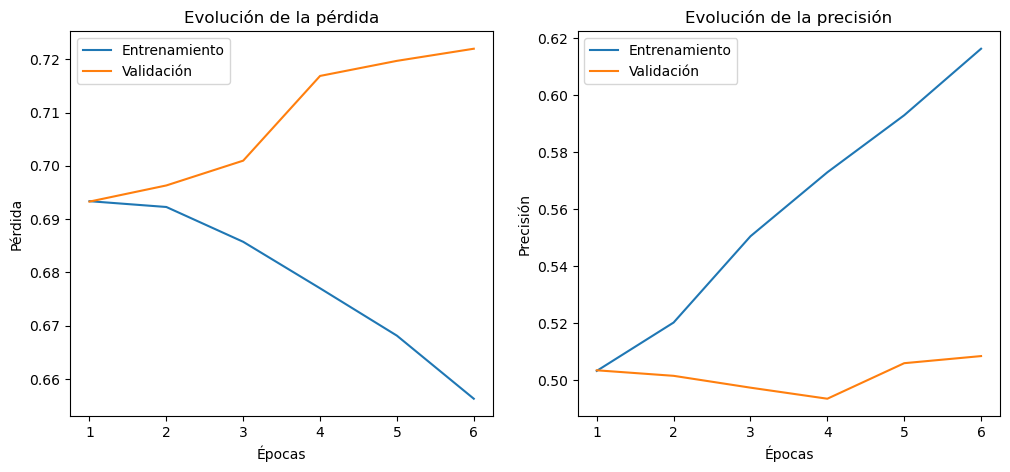

113/113 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - accuracy: 0.5086 - loss: 0.6932
Epoch 1/35
452/452 ━━━━━━━━━━━━━━━━━━━━ 68s 144ms/step - accuracy: 0.5005 - loss: 0.6934 - val_accuracy: 0.5024 - val_loss: 0.6931
Epoch 2/35
452/452 ━━━━━━━━━━━━━━━━━━━━ 64s 142ms/step - accuracy: 0.5203 - loss: 0.6925 - val_accuracy: 0.5040 - val_loss: 0.6931
Epoch 3/35
452/452 ━━━━━━━━━━━━━━━━━━━━ 63s 140ms/step - accuracy: 0.5540 - loss: 0.6844 - val_accuracy: 0.5007 - val_loss: 0.6979
Epoch 4/35
452/452 ━━━━━━━━━━━━━━━━━━━━ 69s 153ms/step - accuracy: 0.5793 - loss: 0.6749 - val_accuracy: 0.4996 - val_loss: 0.7058
Epoch 5/35
452/452 ━━━━━━━━━━━━━━━━━━━━ 69s 152ms/step - accuracy: 0.6026 - loss: 0.6644 - val_accuracy: 0.4888 - val_loss: 0.7198
Epoch 6/35
452/452 ━━━━━━━━━━━━━━━━━━━━ 66s 146ms/step - accuracy: 0.6225 - loss: 0.6457 - val_accuracy: 0.4949 - val_loss: 0.7307


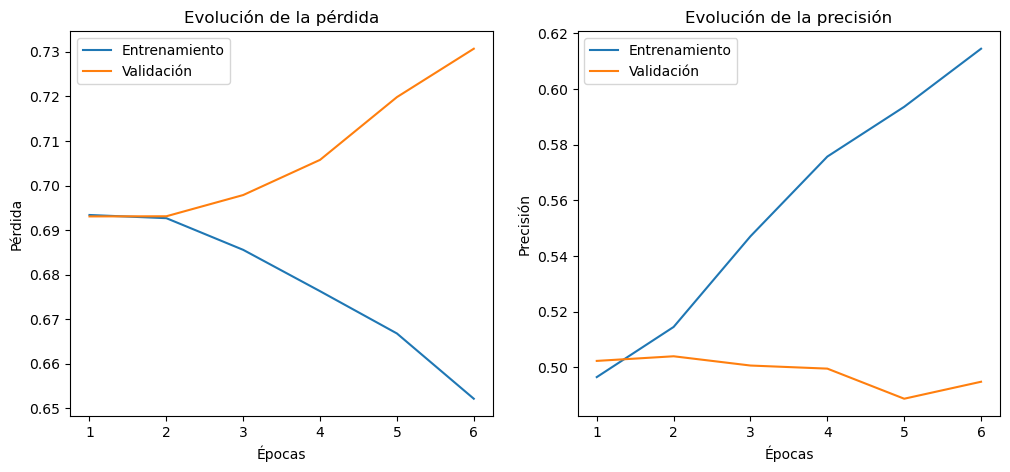

113/113 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - accuracy: 0.5042 - loss: 0.6931
Epoch 1/35
452/452 ━━━━━━━━━━━━━━━━━━━━ 68s 144ms/step - accuracy: 0.5143 - loss: 0.6932 - val_accuracy: 0.4877 - val_loss: 0.6932
Epoch 2/35
452/452 ━━━━━━━━━━━━━━━━━━━━ 68s 150ms/step - accuracy: 0.5194 - loss: 0.6924 - val_accuracy: 0.4929 - val_loss: 0.6951
Epoch 3/35
452/452 ━━━━━━━━━━━━━━━━━━━━ 73s 162ms/step - accuracy: 0.5623 - loss: 0.6839 - val_accuracy: 0.4924 - val_loss: 0.7031
Epoch 4/35
452/452 ━━━━━━━━━━━━━━━━━━━━ 64s 142ms/step - accuracy: 0.5895 - loss: 0.6719 - val_accuracy: 0.4976 - val_loss: 0.7115
Epoch 5/35
452/452 ━━━━━━━━━━━━━━━━━━━━ 67s 149ms/step - accuracy: 0.6025 - loss: 0.6624 - val_accuracy: 0.4913 - val_loss: 0.7196
Epoch 6/35
452/452 ━━━━━━━━━━━━━━━━━━━━ 58s 129ms/step - accuracy: 0.6290 - loss: 0.6470 - val_accuracy: 0.4965 - val_loss: 0.7411


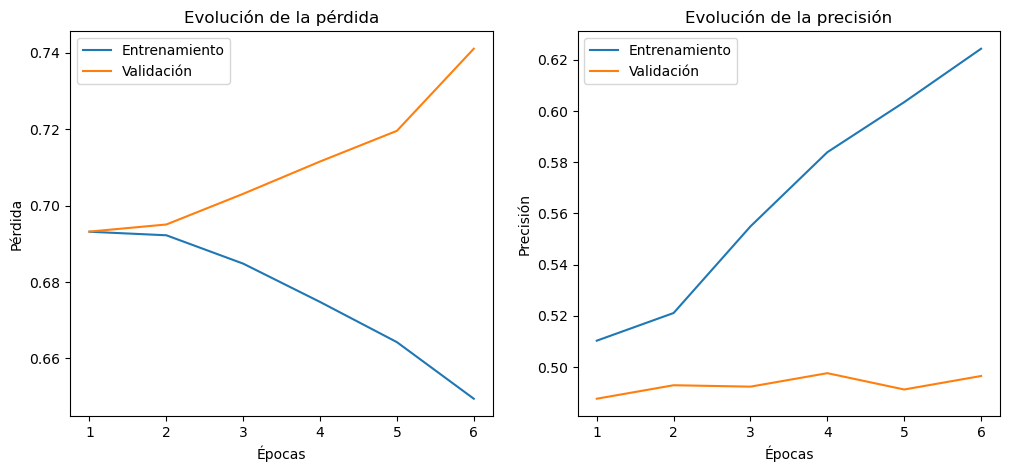

113/113 ━━━━━━━━━━━━━━━━━━━━ 5s 43ms/step - accuracy: 0.4929 - loss: 0.6930


In [9]:
# Dividimos el dataset en entrenamiento y prueba. Usamos KFold para la validación cruzada
# con 5 pliegues

# Definimos el número de pliegues
K = 5 # se dividirá el dataset en 5 partes

kf = KFold(n_splits=K, shuffle=True, random_state=42) # Creamos el objeto KFold

# Lista para almacenar las precisiones de cada iteración
precisiones = [] # Lista para almacenar las precisiones de cada iteración

for train_index, test_index in kf.split(final): # Iteramos sobre los pliegues
    X_train, X_test = final[train_index], final[test_index] # Dividimos el dataset en entrenamiento y prueba
    y_train, y_test = news["label"].values[train_index], news["label"].values[test_index] # Dividimos el dataset en entrenamiento y prueba

    modelo = Sequential([
        Embedding(input_dim=5000, output_dim=64, input_length=secuencias.shape[1]), 
        LSTM(50,activation='tanh', dropout=0.3), # Capa LSTM con 100 unidades y función de activación tanh. dropout del 20% para evitar el sobreajuste
        Dense(16, activation='relu'), # Procesa categorías y fuentes. probar luego con 64.
        Dense(1, activation='sigmoid') # Capa de salida. Salida binaria (noticia falsa o no)
    ]) # Modelo secuencial con una capa de embedding, una capa LSTM y dos capas densas

    # Compilamos el modelo
    modelo.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy']) # Compilamos el modelo con el optimizador Adam y la función de pérdida binary_crossentropy

    early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True) # Early stopping para evitar el sobreajuste. Monitorea la pérdida de validación y restaura los mejores pesos

    # Entrenamos el modelo con datos de validación
    historial = modelo.fit(X_train, y_train, epochs=35, batch_size=32, validation_data=(X_test,y_test), callbacks=[early_stop]) # Entrenamos el modelo con 5 épocas y tamaño de lote de 32. bath_size=32 significa que se procesarán 32 muestras a la vez

    # Obtener los datos de pérdida y precisión
    epochs = range(1, len(historial.history['loss']) + 1)

    # Gráfico de pérdida
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, historial.history['loss'], label='Entrenamiento')
    plt.plot(epochs, historial.history['val_loss'], label='Validación')
    plt.xlabel('Épocas')
    plt.ylabel('Pérdida')
    plt.title('Evolución de la pérdida')
    plt.legend()

    # Gráfico de precisión
    plt.subplot(1, 2, 2)
    plt.plot(epochs, historial.history['accuracy'], label='Entrenamiento')
    plt.plot(epochs, historial.history['val_accuracy'], label='Validación')
    plt.xlabel('Épocas')
    plt.ylabel('Precisión')
    plt.title('Evolución de la precisión')
    plt.legend()

    plt.show()

    # Evaluamos el modelo con la partición de prueba	
    accuracy = modelo.evaluate(X_test, y_test)[1] # Evaluamos el modelo
    precisiones.append(accuracy) # Almacenamos la precisión



In [11]:
# Calcular la precisión promedio
precision_final = np.mean(precisiones) # Calculamos la precisión promedio

print (precisiones)

print(f"Precisión promedio con K-Fold Cross Validation (K={K}): {precision_final:.2f}")



nuevo_texto = "Joe Biden, Presidente de EEUU, ha dimitido."
# Convertimos el nuevo texto a secuencias
secuencia = tokenizer.texts_to_sequences([nuevo_texto]) # Convertimos el texto a secuencias
secuencia_padded = pad_sequences(secuencia, maxlen=200, padding='post', truncating='post') # Rellenamos la secuencia para que tenga la misma longitud

## Supongamos que pertenece a la categoría "Política" y es de "CNN"
nuevas_caracteristicas = np.array([[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 200, 1500]])  # Simulación de valores

# Concatenamos la secuencia con las nuevas características
entrada_final = np.hstack((secuencia_padded, nuevas_caracteristicas)) # Fusionamos la secuencia y las nuevas características

# Realizamos la predicción
predicciones = modelo.predict(entrada_final) # Predecimos el nuevo texto
print(f"Predicción para el nuevo texto: {predicciones[0][0]:.2f}") # Mostramos la predicción
# Mostramos la predicción

# convertir la predicción a una etiqueta
Etiqueta = "Noticia falsa" if predicciones[0][0] > 0.4 else "Noticia verdadera"

print(f"Esta es una {Etiqueta}") # Mostramos la etiqueta

# Convertir las probabilidades en etiquetas binarias (0 = verdadero, 1 = falso)
predicciones_binario = np.where(predicciones >= 0.4, 1, 0)

# Evaluar el modelo con el conjunto de prueba
predicciones_test = modelo.predict(X_test)
predicciones_test_binario = np.where(predicciones_test >= 0.4, 1, 0)
matriz_confusion = confusion_matrix(y_test, predicciones_test_binario)
print("Matriz de confusión:")
print(matriz_confusion)
print("Explicación de la matriz de confusión:")
print("[TN, FP]")
print("[FN, TP]")

reporte_clasificacion = classification_report(y_test, predicciones_test_binario)
print("Reporte de clasificación:")
print(reporte_clasificacion)

[0.5006927251815796, 0.4973676800727844, 0.5034635663032532, 0.5023552179336548, 0.4876697063446045]
Precisión promedio con K-Fold Cross Validation (K=5): 0.50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 519ms/step
Predicción para el nuevo texto: 0.50
Esta es una Noticia falsa
113/113 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step
Matriz de confusión:
[[   0 1809]
 [   0 1800]]
Explicación de la matriz de confusión:
[TN, FP]
[FN, TP]
Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1809
           1       0.50      1.00      0.67      1800

    accuracy                           0.50      3609
   macro avg       0.25      0.50      0.33      3609
weighted avg       0.25      0.50      0.33      3609



c:\Users\aleja\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\aleja\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\aleja\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
